Starting cell as per wishbone analysis: W30258

Genes they show in their notebook: 'CD34', 'GATA1', 'GATA2', 'MPO'
Mixture of factor analysers top 3 out of 69: ELANE, SRGN and CAR2

In [15]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12,6)
matplotlib.style.use('ggplot')
%matplotlib inline
import pandas as pd
import numpy as np
import GPy
import pickle
from sklearn.decomposition import PCA
import matplotlib.cm as cm
# plotly
import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)

In [16]:
monocleDimRed = pd.read_csv('monocle/monocleDimRed.csv', index_col=[0]).T
monoclePT = pd.read_csv('monocle/monoclePT.csv', index_col=[0])
monoclePT = monoclePT / monoclePT.max()  # [0,1]
print(monocleDimRed.shape)
print(monoclePT.shape)
monocleState = pd.read_csv('monocle/monocleState.csv', index_col=[0])
print(monocleState.shape)
monocleDimRed.head()

(4423, 2)
(4423, 1)
(4423, 1)


,1,2
1,0.728425,-4.253484
2,3.131191,-2.867801
3,-3.106984,-4.869838
4,3.960245,-7.332075
5,-0.881536,-5.958776


In [17]:
# read data
data = pd.read_csv('wishbone_rna_seq.csv', index_col=[0])
print(data.shape)
assert np.all(data.shape ==  (4423, 2312)) # 4423 cells x 2312 genes
data.head() 

(4423, 2312)


,SRRM1,ZFP106,TAB2,TXNRD2,GRINL1A,SSRP1,EPDR1,GPX4,ALOX5AP,CDK5R1,...,ERO1L,POC1A,NFATC3,ERP29,HYOU1,BC024571,SCNN1A,CBR1,GTF2I,AK153575
W29956,0.000000,0.0,1.189415,0.000000,1.189415,0.000000,0.0,1.189415,0.0,0.0,...,0.0,0.000000,0.000000,1.189415,0.0,0.00000,0.0,0.0,0.000000,0.000000
W30018,1.302822,0.0,0.000000,0.000000,1.302822,5.211289,0.0,0.000000,0.0,0.0,...,0.0,1.302822,1.302822,0.000000,0.0,0.00000,0.0,0.0,0.000000,1.302822
W30161,4.095923,0.0,0.000000,0.000000,0.000000,8.191847,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000
W30203,0.777070,0.0,0.000000,0.000000,0.000000,1.554140,0.0,1.554140,0.0,0.0,...,0.0,0.000000,0.000000,1.554140,0.0,0.77707,0.0,0.0,3.108280,0.000000
W30258,1.269889,0.0,0.000000,1.269889,1.269889,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,1.269889,0.0,0.00000,0.0,0.0,1.269889,0.000000


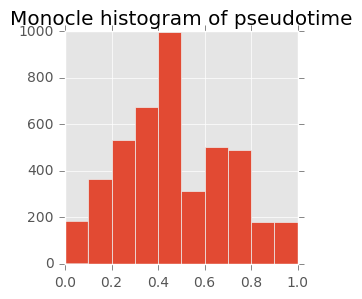

In [18]:
f, ax = plt.subplots(1, 1, figsize=(3,3), sharey=True)
ax.hist(monoclePT.values)
ax.set_title('Monocle histogram of pseudotime')

In [19]:
startingCell = 'W30258'
idxFirstCell = np.flatnonzero(startingCell == data.index)

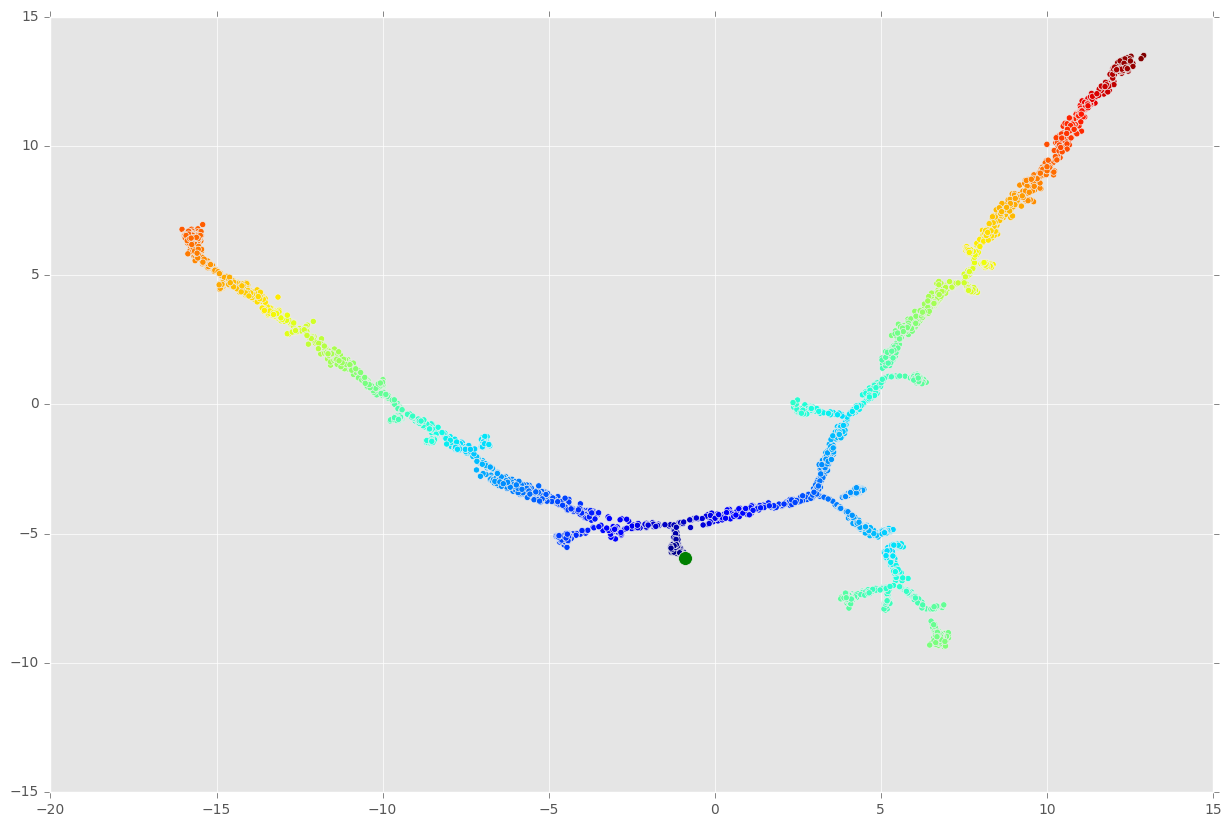

In [20]:
f, ax = plt.subplots(1, 1, figsize=(15,10))
h=ax.scatter(monocleDimRed.values[:,0], monocleDimRed.values[:,1], c=monoclePT.values)
ax.scatter(monocleDimRed.values[idxFirstCell, 0], monocleDimRed.values[idxFirstCell, 1],
           c='g', s=100)  # mark start cell

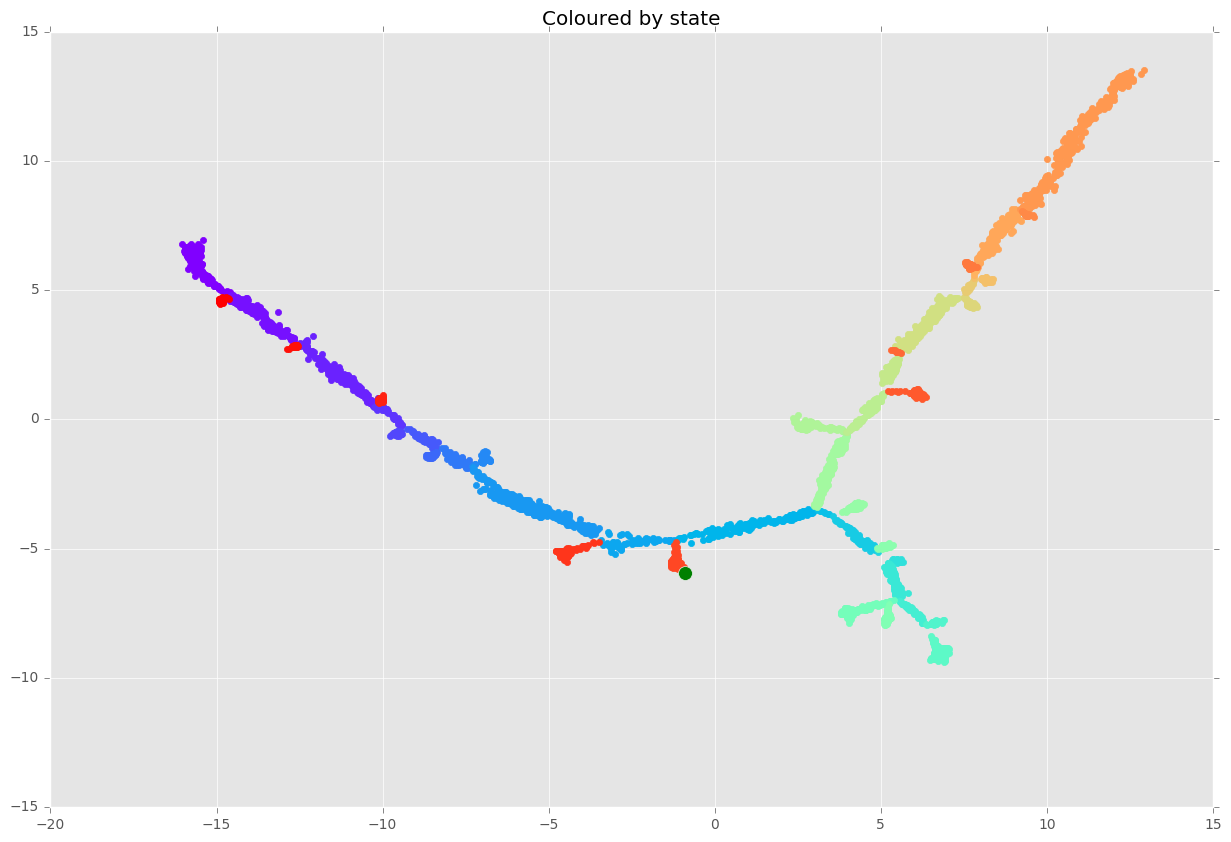

In [23]:
f, ax = plt.subplots(1, 1, figsize=(15,10))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(monocleState.values))))
for st, c in zip(np.unique(monocleState.values), colors):
    idx = (monocleState==st).values.flatten()
    ax.scatter(monocleDimRed.values[idx,0], monocleDimRed.values[idx,1], color=c, label=st)
    ax.set_title('Coloured by state')
ax.scatter(monocleDimRed.values[idxFirstCell, 0], monocleDimRed.values[idxFirstCell, 1], c='g', s=100)  # mark start cell

In [22]:
print('State where starting cell belongs in', monocleState.iloc[idxFirstCell].values.flatten())

State where starting cell belongs in [41]


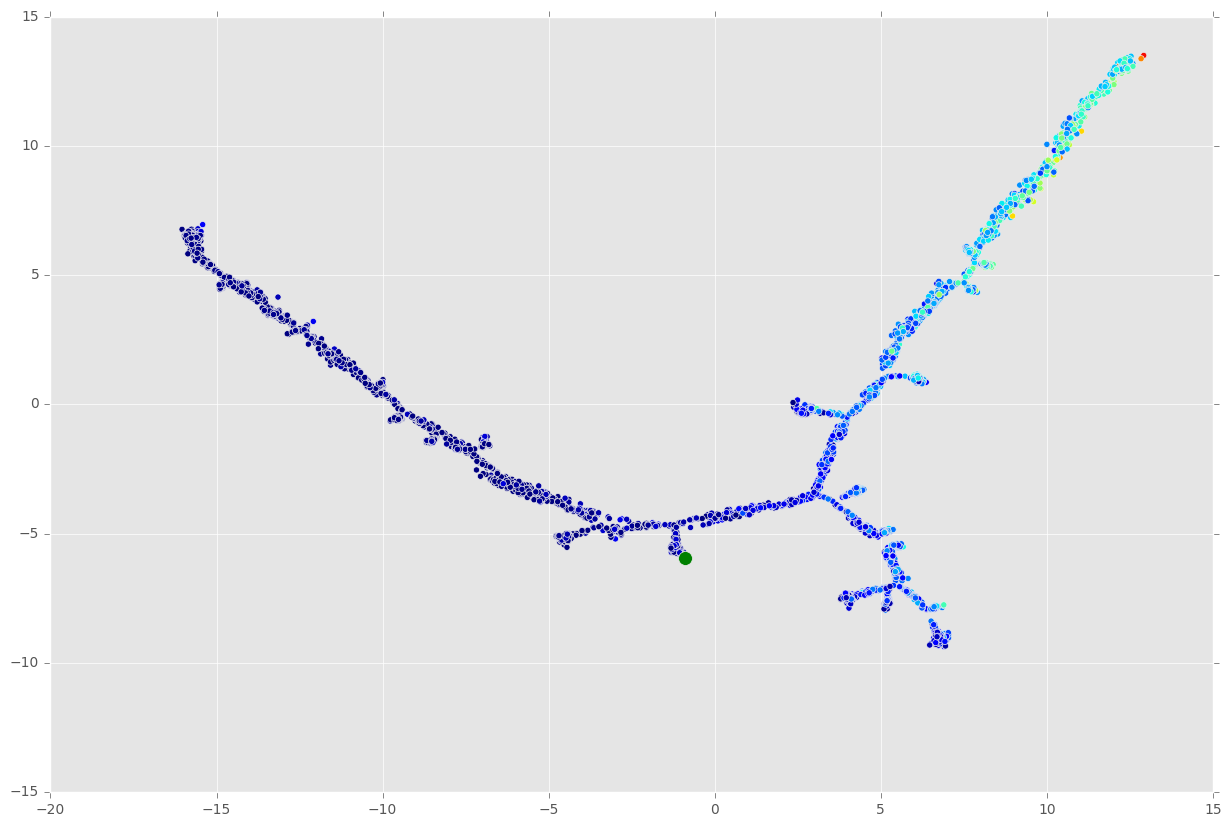

In [25]:
f, ax = plt.subplots(1, 1, figsize=(15,10))
h=ax.scatter(monocleDimRed.values[:,0], monocleDimRed.values[:,1], c=data['MPO']/data['MPO'].max())
ax.scatter(monocleDimRed.values[idxFirstCell, 0], monocleDimRed.values[idxFirstCell, 1],
           c='g', s=100)  # mark start cell

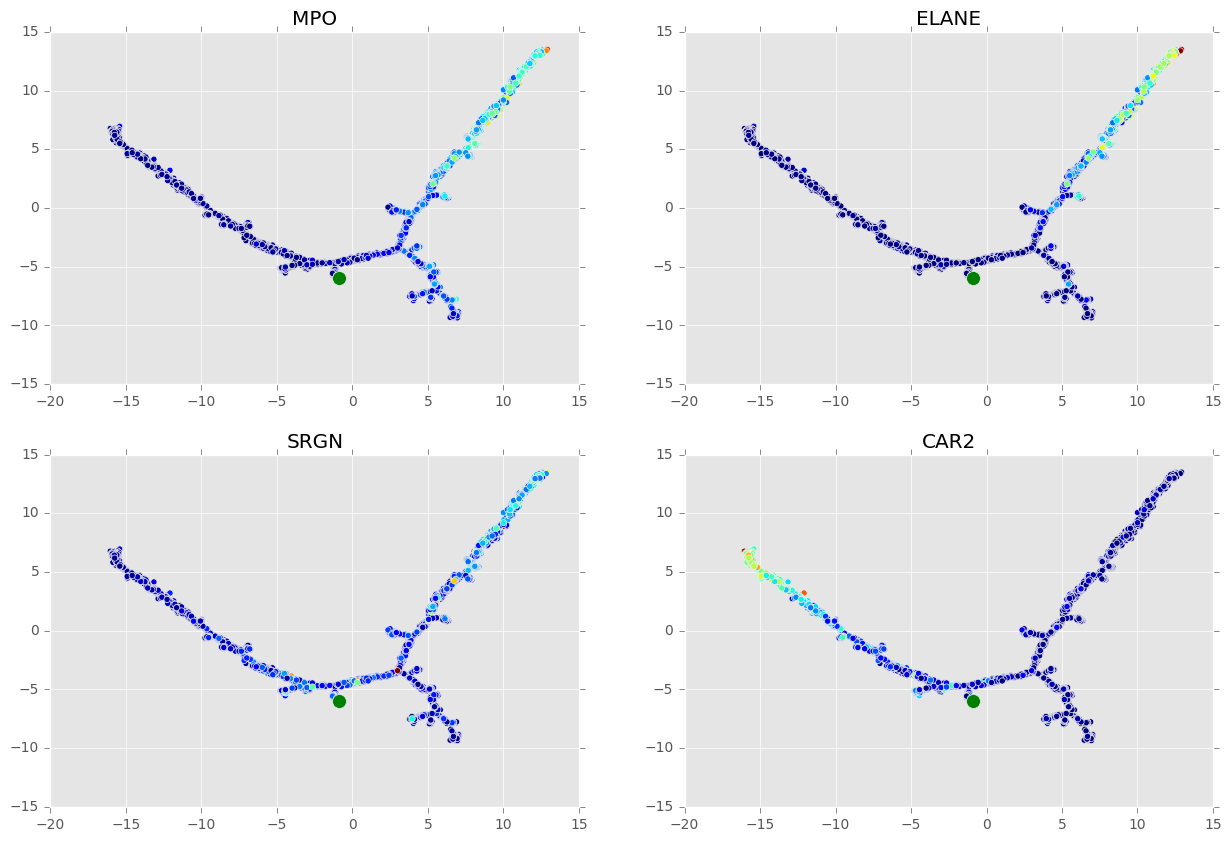

In [34]:
interestingGenes = ['MPO', 'ELANE', 'SRGN', 'CAR2']
f, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.flatten()
for ig, g in enumerate(interestingGenes):
    Y = data[g]/data[g].max()
    h=ax[ig].scatter(monocleDimRed.values[:,0], monocleDimRed.values[:,1], c=Y)
    ax[ig].scatter(monocleDimRed.values[idxFirstCell, 0], monocleDimRed.values[idxFirstCell, 1],
           c='g', s=100)  # mark start cell
    ax[ig].set_title(g)